## Optimal statistic with discovery

In [1]:
import sys
import os
import glob

import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [3]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [4]:
import discovery as ds

Read nanograv pulsars

In [5]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

Run with fewer pulsars

In [6]:
psrs = allpsrs[:5]

Set up GlobalLikelihood object. The GP named 'gw' will be used to build the optimal statistic; everything else will be included in individual pulsar noise. This GW object should be identical for every pulsar, and have common parameters only.

In [259]:
Tspan = ds.getspan(psrs)
t0 = ds.getstart(psrs)

gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True, variable=True),
                                                ds.makegp_fftcov(psr, ds.powerlaw, 61, oversample=6, T=Tspan, name='red_noise'),
                                                ds.makegp_fftcov(psr, ds.brokenpowerlaw, 61, oversample=6, T=Tspan, t0=t0,
                                                                 common=['gw_log10_A', 'gw_gamma', 'gw_log10_fb'], name='gw')
                                                ]) for psr in psrs])

### Basic OS

Make OS object

In [9]:
%time os = ds.OS(gbl)

CPU times: user 44.8 ms, sys: 2.52 ms, total: 47.3 ms
Wall time: 45.9 ms


Get a random set of parameters, force gamma to 13/3

In [10]:
p0 = ds.sample_uniform(os.params, priordict={'gw_(.*_)?gamma': [13/3,13/3]})

Compute the OS for the data. You get also the corresponding sigma, SNR, and the amplitude of the GW.

In [11]:
os.os(p0)

{'os': Array(5.9910104e-30, dtype=float64),
 'os_sigma': Array(1.99077814e-27, dtype=float64),
 'snr': Array(0.00300938, dtype=float64),
 'log10_A': -12.96304169401837}

### Alternative ORFs

The ORF takes only one parameter (the product `z = dot(pos1, pos2)`). Discovery predefines `hd_orfa`, `monopole_orfa`, `dipole_orfa`.

In [63]:
os.os(p0, ds.monopole_orfa)

{'os': Array(5.50934365e-30, dtype=float64),
 'os_sigma': Array(1.03401729e-29, dtype=float64),
 'snr': Array(0.53280963, dtype=float64),
 'log10_A': -12.11677005017712}

In [64]:
os.os(p0, ds.dipole_orfa)

{'os': Array(7.35383537e-30, dtype=float64),
 'os_sigma': Array(1.75419332e-29, dtype=float64),
 'snr': Array(0.41921465, dtype=float64),
 'log10_A': -12.11677005017712}

### "Marginalized" OS 

Create a population of parameters (normally we'd get them from an MCMC run).

In [65]:
p0s = ds.sample_uniform(os.params, priordict={'gw_(.*_)?gamma': [13/3,13/3]}, n=5)

In [66]:
p0s['B1855+09_red_noise_gamma']

array([0.89509136, 4.93412033, 3.98655564, 1.34624826, 5.96623953])

Then we `jax.vmap` over parameter sets

In [67]:
os_vpar = jax.vmap(os.os)

In [68]:
os_vpar(p0s)

{'log10_A': array([-15.38365639, -14.23822937, -14.7741985 , -13.83253618,
        -12.85009408]),
 'os': Array([ 1.09293369e-29,  4.94251978e-30,  1.83796125e-30, -8.71881909e-30,
         2.06918798e-30], dtype=float64),
 'os_sigma': Array([8.25075514e-31, 5.87877944e-31, 4.84132509e-31, 2.30306809e-30,
        4.59172685e-30], dtype=float64),
 'snr': Array([13.24646861,  8.40739108,  3.79640122, -3.78574092,  0.45063394],      dtype=float64)}

### Scrambles

`os.scramble` takes as a second argument an array (or list) of pulsar positions of dimension `(npsr, 3)`

In [69]:
jnp.array(os.pos)

Array([[ 0.235276  , -0.95735312,  0.16769083],
       [ 0.38400231, -0.84770959,  0.36596539],
       [ 0.41542527, -0.76954724,  0.4849937 ],
       [ 0.98151466,  0.10005025,  0.16315308],
       [ 0.98761743,  0.1320268 ,  0.08473928],
       [ 0.42846049,  0.61411581,  0.66278457],
       [ 0.40865968,  0.75692046,  0.5099693 ],
       [ 0.23974131,  0.63501757, -0.73435467],
       [ 0.21645786,  0.96384399,  0.15540512],
       [ 0.01039278,  0.96199519,  0.27286854]], dtype=float64)

In [70]:
os.scramble(p0, jnp.array(os.pos))

{'os': Array(-3.83283248e-30, dtype=float64),
 'os_sigma': Array(4.35015195e-29, dtype=float64),
 'snr': Array(-0.08810801, dtype=float64),
 'log10_A': -12.11677005017712}

To build a background you'll want a random array of positions of dimension `(nscramble, npsr, 3)`

In [71]:
key = ds.matrix.jnpkey(42)
rpos = jax.random.normal(key, (15, len(psrs), 3))
npos = rpos / jnp.linalg.norm(rpos, axis=2)[:,:,None] # normalize vectors

Then we `jax.vmap` over positions (the second argument).

In [72]:
scramble_vpos = jax.vmap(os.scramble, (None,0))

In [73]:
scramble_vpos(p0, npos)

{'log10_A': Array([-12.11677005, -12.11677005, -12.11677005, -12.11677005,
        -12.11677005, -12.11677005, -12.11677005, -12.11677005,
        -12.11677005, -12.11677005, -12.11677005, -12.11677005,
        -12.11677005, -12.11677005, -12.11677005],      dtype=float64, weak_type=True),
 'os': Array([ 1.95249806e-29,  1.81802271e-29,  2.09065617e-30,  5.97532235e-30,
        -5.60806608e-29, -7.20305872e-30,  1.25598639e-29, -2.93565709e-29,
        -5.66463939e-30,  2.57360339e-29, -4.86104165e-29, -1.53192259e-29,
         9.88381790e-31, -1.09649446e-30, -7.70309569e-30], dtype=float64),
 'os_sigma': Array([8.33156373e-29, 1.08359434e-28, 3.68741026e-29, 6.98922008e-29,
        1.02361543e-28, 9.82447774e-29, 6.26563180e-29, 7.74374387e-29,
        5.41309179e-29, 5.00710894e-29, 8.15971780e-29, 8.88932359e-29,
        6.98856407e-29, 7.25703275e-29, 6.73513784e-29], dtype=float64),
 'snr': Array([ 0.23434953,  0.16777706,  0.05669714,  0.08549341, -0.54786846,
        -0.0733174

### Phase shifts

These require a diagonal Fourier GW object.

In [191]:
gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True),
                                                ds.makegp_fourier(psr, ds.brokenpowerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.brokenpowerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma', 'gw_log10_fb'], name='gw')
                                                ]) for psr in psrs])

In [192]:
os = ds.OS(gbl)

In [193]:
os.os(p0)

{'os': Array(-4.30823733e-27, dtype=float64),
 'os_sigma': Array(6.93011257e-25, dtype=float64),
 'snr': Array(-0.00621669, dtype=float64),
 'log10_A': -11.735012908976142}

`os.shift` takes as a second argument an array (or list) of pulsar positions of dimension `(npsr, nfreq)`.

Sanity check...

In [194]:
zero = jnp.zeros((len(psrs),14))
os.shift(p0, zero)

{'os': Array(-4.30823733e-27, dtype=float64),
 'os_sigma': Array(6.93011257e-25, dtype=float64),
 'snr': Array(-0.00621669, dtype=float64),
 'log10_A': -11.735012908976142}

In [195]:
key = ds.matrix.jnpkey(42)
phases = 2.0 * jnp.pi * jax.random.uniform(key, shape=(20,10,14))

Then we `jax.vmap` over phases (the second argument).

In [196]:
shift_vphase = jax.vmap(os.shift, (None,0))

In [197]:
shift_vphase(p0, phases)

{'log10_A': Array([-11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291],      dtype=float64, weak_type=True),
 'os': Array([ 3.33941002e-27, -7.33895271e-28,  8.43668277e-28,  6.88771478e-28,
        -4.11956898e-27, -4.53248655e-27, -1.41526412e-28,  3.27782405e-29,
         2.40576463e-27,  4.13801015e-28,  1.67877729e-27,  7.12885800e-28,
        -2.09995848e-28, -4.57350093e-28, -3.42784005e-27,  4.21363613e-27,
        -1.01422436e-27,  2.77293787e-27, -4.00326034e-28,  1.39401202e-27],      dtype=float64),
 'os_sigma': Array([6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e-25,
        6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e-25,
        6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e

### Plotting correlation coefficients

Build a NANOGrav 15-yr model using all the pulsars.

In [25]:
import importlib

In [24]:
import discovery.ostat as ostat

In [197]:
importlib.reload(ds.signals)
importlib.reload(ds)
importlib.reload(ostat)

<module 'discovery.ostat' from '/Users/vallis/Documents/discovery/src/discovery/ostat.py'>

In [6]:
Tspan = ds.getspan(allpsrs)

gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in allpsrs])

Get the MAP parameter set from an actual MCMC run on 15-yr NANOGrav data

In [8]:
df = pd.read_feather('../data/NG15yr-m2a-chain.feather')

In [9]:
p0 = df.iloc[df['logp'].argmax()].to_dict()

Sanity check

In [ ]:
os = ds.OS(gbl)

In [47]:
os.os(p0)

{'os': Array(4.80080526e-29, dtype=float64),
 'os_sigma': Array(9.44338793e-30, dtype=float64),
 'snr': Array(5.08377427, dtype=float64),
 'log10_A': -14.186517715454102}

Simple minded correlation plot: get angles and bin the data

In [16]:
def oscorr(os, p0, nbins=10):
    iota = np.arccos(jnp.array(os.angles)) * (180 / np.pi)

    bins = np.linspace(0, 180, nbins + 1)
    indices = np.digitize(iota, bins) - 1
    masks = [np.where(indices == i)[0] for i in range(nbins)]

    # orfs = ds.hd_orfa(np.array(os.angles))
    orfs = np.ones_like(os.angles)

    rhos, sigmas = os.os_rhosigma(p0)
    gwnorm = 10**(2.0 * p0[os.gwpar])
    rhos, sigmas = gwnorm * rhos, gwnorm * sigmas
    
    iotas = [np.mean(iota[mask]) for mask in masks]
    oses = [np.sum(rhos[mask] * orfs[mask] / sigmas[mask]**2) / np.sum(orfs[mask]**2 / sigmas[mask]**2)
            for mask in masks]
    osigs = [1 / np.sqrt(np.sum(orfs[mask]**2 / sigmas[mask]**2))
           for mask in masks]

    return iotas, oses, osigs

In [17]:
iotas, oses, osigs = oscorr(os, p0)

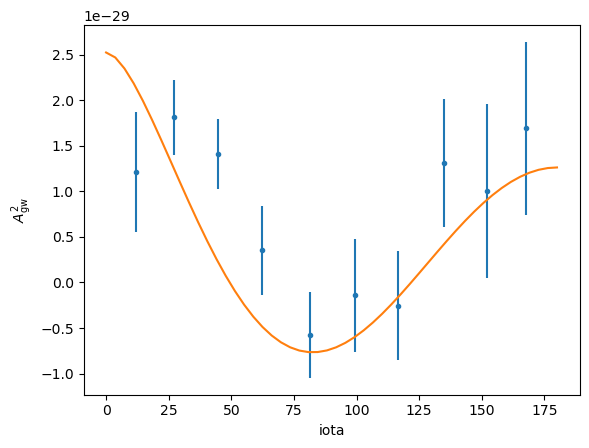

In [18]:
pp.errorbar(iotas, oses, yerr=osigs, fmt='.')

a = np.linspace(1e-6, 180)
hd = ost.os(p0)['os'] * ds.hd_orfa(np.cos(a * (np.pi/180.0)))

pp.plot(a, hd)
pp.xlabel('iota'); pp.ylabel(r'$A_\mathrm{gw}^2$');

Plot the distribution of SNRs on a subchain

In [19]:
chain = df.sample(1000).astype(np.float64)
p0s = {var: jnp.array(chain[var]) for var in df.columns}

In [20]:
vos = jax.jit(jax.vmap(os.os))

In [21]:
%time oses = vos(p0s)

CPU times: user 33.1 s, sys: 1.13 s, total: 34.2 s
Wall time: 34.1 s


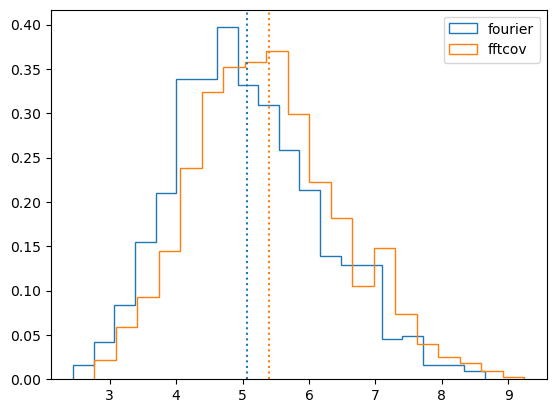

In [31]:
pp.hist(oses['snr'], histtype='step', bins=20, density=True, label='fourier');
# pp.hist(ostes['snr'], histtype='step', bins=20, density=True, label='fftcov');
pp.axvline(np.mean(oses['snr']), color='C0', ls=':');
# pp.axvline(np.mean(ostes['snr']), color='C1', ls=':');
pp.legend()

### Rapid sim

In [172]:
import importlib
import discovery.os as ostat

importlib.reload(ostat)

<module 'discovery.os' from '/Users/vallis/Documents/discovery/src/discovery/os.py'>

In [7]:
Tspan = ds.getspan(allpsrs[:4])

sim = ds.GlobalLikelihood([ds.PulsarLikelihood([ds.makedelay(psr, ds.getresiduals, name='sim'), 
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                # ds.makegp_ecorr(psr, psr.noisedict), # cannot do fixed GP at this time 
                                                ds.makegp_timing(psr, variance=1e-12, variable=True),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in allpsrs[:4]])

In [8]:
os = ds.os.OS(sim)

In [10]:
df = pd.read_feather('../data/NG15yr-m2a-chain.feather')
p0 = df.iloc[df['logp'].argmax()].to_dict()

In [11]:
os.os({**p0, **{f'{psr.name}_sim_y': psr.residuals for psr in allpsrs[:4]}})

{'os': Array(-2.41053159e-28, dtype=float64),
 'os_sigma': Array(1.79208965e-28, dtype=float64),
 'snr': Array(-1.34509542, dtype=float64),
 'log10_A': -14.186517715454102}

In [12]:
oss = os.sample_rhosigma(p0)

In [ ]:
voss = jax.jit(jax.vmap(oss))

In [223]:
n = 10000

In [179]:
%time snrs=voss(ds.matrix.jnpnormal(key, (n, oss.cnt))).block_until_ready()

CPU times: user 3.15 s, sys: 599 ms, total: 3.74 s
Wall time: 875 ms


In [226]:
snrs = []
for i in range(10):
 snrs.append(voss(ds.matrix.jnpnormal(key, (n, oss.cnt))).block_until_ready())
snrs = jnp.concatenate(snrs)

In [26]:
joss, doss, voss = jax.jit(oss), jax.jit(jax.grad(oss)), jax.jit(jax.vmap(oss))
Q = lambda x: 0.5 * doss(x)

In [23]:
x = ds.matrix.jnpnormal(ds.matrix.jnpkey(42), oss.cnt)

In [24]:
joss(x)

Array(-0.61385414, dtype=float64)

In [28]:
x.T @ Q(x)

Array(-0.61385414, dtype=float64)

In [188]:
%timeit joss(ds.matrix.jnpnormal(key, oss.cnt))

4.59 ms ± 32 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [189]:
%timeit doss(ds.matrix.jnpnormal(key, oss.cnt))

8.49 ms ± 26.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Estimate $\lambda_\mathrm{max}$

In [29]:
def estimate_spectral_norm(Q, n, num_iters=20, seed=42):
    v = jax.random.normal(ds.matrix.jnpkey(seed), n)
    
    v = v / jnp.linalg.norm(v)
    for _ in range(num_iters):
        v = Q(v)
        norm_v = jnp.linalg.norm(v)
        if norm_v == 0:
            return 0.0
        v = v / norm_v

    return jnp.abs(jnp.dot(v, Q(v)))

In [35]:
Qnorm = estimate_spectral_norm(Q, oss.cnt, 40)

This means the maximum $\theta$ is $1 / (2 \lambda_\mathrm{max})$.

In [36]:
Qnorm, 1 / (2 * Qnorm)

(Array(0.22945884, dtype=float64), Array(2.17904, dtype=float64))

Solve $\mathrm{tr} (Q (I - 2 \theta Q)^{-1}) = s$, where $s$ is the desired tail value.

In [45]:
def rademacher(key, shape):
    return 2.0 * jax.random.randint(key, shape=shape, minval=0, maxval=2) - 1.0

In [56]:
def get_trace(theta, Q, n, m=20, seed=42):
    keys = ds.matrix.jnpsplit(jax.random.PRNGKey(seed), m)
    
    matvec = lambda v: v - 2 * theta * Q(v)

    return np.mean([jnp.dot(z, Q(jax.scipy.sparse.linalg.cg(matvec, z)[0]))
                    for z in rademacher(jax.random.PRNGKey(seed), (m, n))])

In [212]:
theta0 = 1.6

In [58]:
tr0 = get_trace(theta0, Q, oss.cnt, 42)
tr0

np.float64(2.656684271396586)

Sample from tilted distribution: $x \sim \mathcal{N}(0, I)$, solve $(I - 2 \theta Q) y = x$.

In [63]:
def sample_sigma(theta, Q, n, m=1, seed=42):
    x = ds.matrix.jnpnormal(jax.random.PRNGKey(seed), (m, oss.cnt))
    matvec = lambda v: v - 2 * theta * Q(v)
    
    return jax.vmap(lambda v: jax.scipy.sparse.linalg.cg(matvec, v)[0])(x)

In [68]:
%time y = sample_sigma(theta0, Q, oss.cnt, 100, 42)

CPU times: user 1.36 s, sys: 343 ms, total: 1.71 s
Wall time: 1.49 s


In [213]:
%time y = sample_sigma(theta0, Q, oss.cnt, 1000, 42)

CPU times: user 2.58 s, sys: 701 ms, total: 3.28 s
Wall time: 1.47 s


Evaluate OS and weights $\exp -\theta x^T Q x$ for these samples. Note weights should be normalized by $\sqrt{\Sigma}$ with $\Sigma = (I - 2\theta Q)^{-1}$.

In [214]:
o = voss(y)
w = jnp.exp(-theta0 * o)

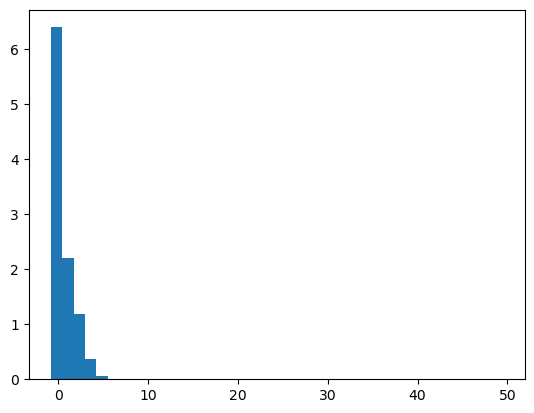

In [215]:
pp.hist(o, weights=w, bins=40);

In [216]:
def makecdf(array, weights=None, xmin=None, xcdf=0):
    if weights is None:
        return np.sort(array), np.arange(1, len(array) + 1) / len(array)
    else:
        if xmin is not None:
            weights = weights[array > xmin]
            array = array[array > xmin]
        
        sort_idx = np.argsort(array)
        return array[sort_idx], xcdf + (1 - xcdf) * np.cumsum(weights[sort_idx]) / np.sum(weights)

In [217]:
oval, cval = makecdf(o, w)

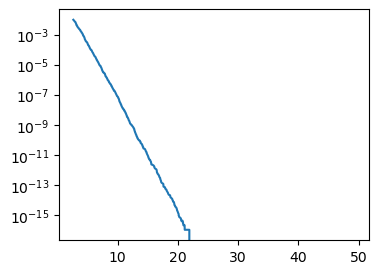

In [224]:
pp.figure(figsize=(4,3))
pp.semilogy(oval, 1 - cval)

In [ ]:
%time oo = voss(ds.matrix.jnpnormal(ds.matrix.jnpkey(42), (10000, oss.cnt))).block_until_ready()

In [235]:
ooval, ccval = makecdf(oo)

Patch the two distributions together.

In [247]:
omatch = 1 * tr0
offset = np.interp(omatch, ooval, ccval) 
oval, cval = makecdf(o, w, omatch, offset)

(np.float64(0.0), np.float64(15.0), np.float64(1e-08), np.float64(0.1))

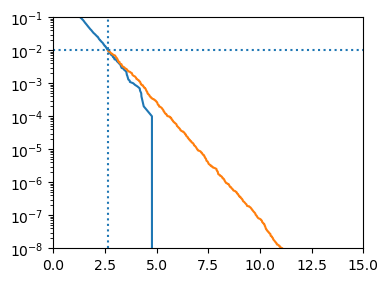

In [248]:
pp.figure(figsize=(4,3))
pp.semilogy(ooval, 1 - ccval)
pp.semilogy(oval, 1 - cval)
pp.axvline(omatch, ls=':'); pp.axhline(1 - offset, ls=':')
pp.axis(xmin=0, xmax=15, ymin=1e-8, ymax=1e-1)

In [205]:
Qnorm = estimate_spectral_norm(matvec, oss.cnt, 100)

In [213]:
def estimate_frobenius_norm(Q_func, n, num_samples=50, seed=42):
    trace_estimate = 0.0

    for i in range(num_samples):
        z = 2.0 * jax.random.randint(ds.matrix.jnpkey(seed + i), shape=(n,), minval=0, maxval=2) - 1.0
        Qz = Q_func(z)
        trace_estimate += jnp.dot(Qz, Qz)

    trace_estimate /= num_samples
    frobenius_norm = jnp.sqrt(trace_estimate)
    return frobenius_norm

In [222]:
QFnorm = estimate_frobenius_norm(matvec, oss.cnt, 100, 42)

In [255]:
survival1 = 2 * jnp.exp(-(1/8) * s**2 / QFnorm**2)

In [257]:
survival2 = 2 * jnp.exp(-(1/8) * s / Qnorm)

In [231]:
s, c = makecdf(snrs)

(np.float64(2.0), np.float64(5.0), np.float64(0.0001), np.float64(0.1))

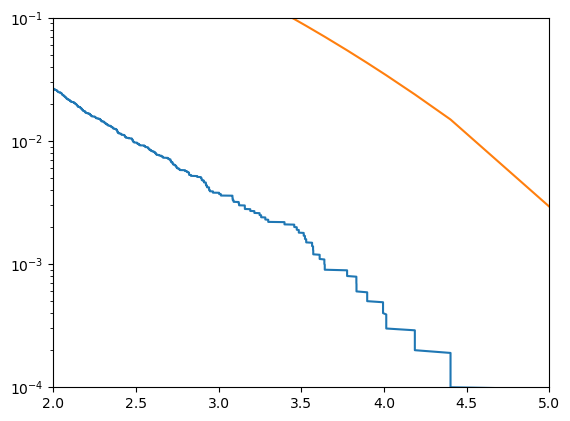

In [267]:
pp.semilogy(s, 1 - c)

pp.semilogy(s, survival)
pp.semilogy(s, survival2)

pp.axis(xmin=2, xmax=5, ymin=1e-4, ymax=1e-1)

### Tilted tail sampling

In [347]:
def matvec(v):
    return v - 2 * theta * 0.5 * doss(v)

In [348]:
def rademacher(key, n):
    return 2.0 * jax.random.randint(key, shape=(n,), minval=0, maxval=2) - 1.0

In [349]:
def get_trace(theta, m=20, key=jax.random.PRNGKey(42)):
    trace_est = 0.0
    for _ in range(m):
        key, subkey = ds.matrix.jnpsplit(key)
        z = rademacher(subkey, oss.cnt)
        trace_est += np.dot(z, doss(jax.scipy.sparse.linalg.cg(lambda v: v - theta * doss(v), z)[0]))
    return trace_est / m

In [337]:
get_trace(0.1, key=jax.random.PRNGKey(43))

np.float64(-0.01703971947728193)

In [338]:
get_trace(0.2, key=jax.random.PRNGKey(43))

np.float64(0.16237751525388971)

In [339]:
get_trace(0.3, key=jax.random.PRNGKey(43))

np.float64(0.3467426477078107)

In [351]:
get_trace(1.5, key=jax.random.PRNGKey(43))

np.float64(3.867240299569159)

In [357]:
def sample_sigma(theta, key=jax.random.PRNGKey(42)):
    key, subkey = ds.matrix.jnpsplit(key)
    x = ds.matrix.jnpnormal(subkey, oss.cnt)
    return key, jax.scipy.sparse.linalg.cg(lambda v: v - theta * doss(v), x)[0]

In [ ]:
vo, vw = [], []
for i in tqdm.tqdm(range(1000)):
    key, x1 = sample_sigma(1.5, key)
    o = oss(x1)
    w = jnp.exp(-1.5 * o)
    vo.append(o)
    vw.append(w)

  8%|█████████▊                                                                                                           | 84/1000 [01:08<11:56,  1.28it/s]

In [ ]:
def lanczos(matvec, v, m):
    """
    Run m steps of Lanczos on (I - 2*theta*Q) using starting vector v.
    Returns:
        - alphas: diagonal entries of T
        - betas: off-diagonal entries of T
    """
    n = v.shape[0]
    
    beta_prev = 0.0
    q_prev = jnp.zeros_like(v)
    q = v / jnp.linalg.norm(v)
    
    alphas = []
    betas = []
    
    for j in range(m):
        w = matvec(q) - beta_prev * q_prev
        alpha = jnp.dot(q, w)
        w = w - alpha * q
        beta = jnp.linalg.norm(w)
        
        alphas.append(alpha)
        betas.append(beta)
        
        q_prev = q
        q = jnp.where(beta > 1e-10, w / beta, q)   # avoid divide by zero
        beta_prev = beta
    
    betas = jnp.array(betas[:-1])  # last beta unused
    alphas = jnp.array(alphas)
    return alphas, betas

In [294]:
def log_trace_from_tridiagonal(alphas, betas):
    """
    Compute e1^T log(T) e1 from T defined by alphas, betas.
    """
    T = jnp.diag(alphas)
    if betas.shape[0] > 0:
        T = T.at[jnp.arange(len(betas)), jnp.arange(1, len(betas)+1)].set(betas)
        T = T.at[jnp.arange(1, len(betas)+1), jnp.arange(len(betas))].set(betas)

    eigvals, eigvecs = jnp.linalg.eigh(T)
    log_eigs = jnp.log(eigvals)
    weights = eigvecs[0, :] ** 2
    return jnp.sum(weights * log_eigs)

In [320]:
def estimate_logdet(matvec, n, num_samples=30, lanczos_steps=10, key=jax.random.PRNGKey(42)):
    keys = jax.random.split(key, num_samples)
    log_traces = []
    
    for k in keys:
        v = jax.random.choice(k, jnp.array([-1.0, 1.0]), shape=(n,))
        v = v / jnp.linalg.norm(v)
        
        alphas, betas = lanczos(matvec, v, lanczos_steps)
        log_trace = log_trace_from_tridiagonal(alphas, betas)
        log_traces.append(log_trace)
    
    logdet_est = jnp.mean(jnp.stack(log_traces))
    return logdet_est

In [328]:
estimate_logdet(matvec, oss.cnt, num_samples=100, lanczos_steps=6)

Array(-1.70486385e-06, dtype=float64)

In [106]:
xs = ds.matrix.jnpnormal(key, oss.cnt)
0.5 * xs.T @ jax.grad(oss)(xs)

Array(-0.38577951, dtype=float64)

In [107]:
oss(xs)

Array(-0.38577951, dtype=float64)

In [83]:
oss(ds.matrix.jnpnormal(key, (100, oss.cnt)))

Array([ 0.36483167, -0.62490848,  0.37543487,  0.03663539, -0.69401098,
        1.32743395, -0.7791543 , -0.55100144, -0.55858581, -1.16300828,
       -1.28403422, -0.35372767,  0.57559881,  0.53311216, -1.37435635,
        0.96541891,  1.68058525,  0.10877546,  1.13169174,  1.59352168,
        0.01857742, -0.35951232, -0.49468275,  0.50376966,  0.19649796,
        1.40603886,  0.46198887, -0.36756025, -0.04997445, -0.68143705,
        0.03807464, -0.10837285, -0.28118007, -0.69391441, -0.72788802,
        0.06069207,  0.9093868 ,  0.23647343,  0.12099958, -0.22389388,
        0.85802271,  1.54176417,  0.02971224,  1.33132291,  0.18095233,
        0.76455502, -1.57663932,  0.47975498, -0.17677378,  0.95957763,
       -0.33487153,  0.77524031,  0.00949535, -0.66636239, -1.39080722,
       -0.05478418, -0.13928131,  0.25150378,  0.45754259,  0.5037931 ,
        2.16954691,  1.39880449,  0.75966486,  1.34160553, -1.17604516,
       -0.15743136,  0.28232148, -0.35077017, -0.92181179,  2.08

In [61]:
%time nsnrs = os.sample_rhosigma(key, p0, 1000).block_until_ready()

CPU times: user 5.28 s, sys: 714 ms, total: 5.99 s
Wall time: 1.6 s


In [6]:
Tspan = ds.getspan(allpsrs)

sim = ds.GlobalLikelihood([ds.PulsarLikelihood([ds.makedelay(psr, ds.getresiduals, name='sim'), 
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                # ds.makegp_ecorr(psr, psr.noisedict), # cannot do fixed GP at this time 
                                                ds.makegp_timing(psr, variance=1e-12, variable=True),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in allpsrs])

In [8]:
os = ds.os.OS(sim)

In [9]:
df = pd.read_feather('../data/NG15yr-m2a-chain.feather')
p0 = df.iloc[df['logp'].argmax()].to_dict()

In [10]:
os.os({**p0, **{f'{psr.name}_sim_y': psr.residuals for psr in allpsrs}})

{'os': Array(8.32615431e-30, dtype=float64),
 'os_sigma': Array(4.83943727e-30, dtype=float64),
 'snr': Array(1.72047985, dtype=float64),
 'log10_A': -14.186517715454102}

In [12]:
key = ds.jnpkey(42)

In [13]:
%time snrs = os.sample_rhosigma(key, p0, 1).block_until_ready()

CPU times: user 45.4 s, sys: 5.46 s, total: 50.9 s
Wall time: 30.3 s


In [16]:
%time snrs = os.sample_rhosigma(key, p0, 100).block_until_ready()

CPU times: user 43.4 s, sys: 5.66 s, total: 49.1 s
Wall time: 27 s


In [19]:
%time snrs = os.sample_rhosigma(key, p0, 1000).block_until_ready()

CPU times: user 1min 21s, sys: 7.56 s, total: 1min 29s
Wall time: 31.7 s


In [21]:
%time snrs = os.sample_rhosigma(key, p0, 10000).block_until_ready()

CPU times: user 6min 59s, sys: 17.1 s, total: 7min 16s
Wall time: 1min 10s


In [43]:
%%time
lsnrs = [snrs]
for i in range(9):
    key, subkey = ds.jnpsplit(key)
    lsnrs.append(os.sample_rhosigma(key, p0, 10000))
lsnrs = jnp.concatenate(lsnrs)

CPU times: user 1h 5min 35s, sys: 3min 28s, total: 1h 9min 3s
Wall time: 11min 2s


In [23]:
def makecdf(array):
    return np.sort(array), np.arange(1, len(array) + 1) / len(array)

(np.float64(1.0), np.float64(6.0), np.float64(1e-05), np.float64(1.0))

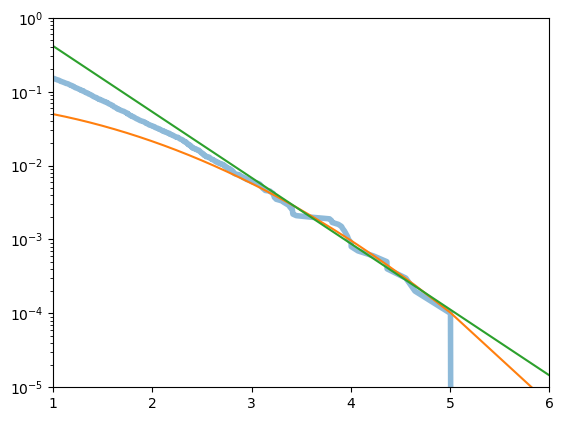

In [47]:
s, c = makecdf(snrs - jnp.mean(snrs))
pp.semilogy(s, 1 - c, lw=4, alpha=0.5)

mask = (s > 3) & (s < 5)
pp.plot(s, jnp.exp(jnp.polyval(jnp.polyfit(s[mask], jnp.log(1 - c[mask]), 2), s)))

mask = (s > 4) & (s < 5)
pp.plot(s, jnp.exp(jnp.polyval(jnp.polyfit(s[mask], jnp.log(1 - c[mask]), 1), s)))

pp.axis(xmin=1, xmax=6, ymin=1e-5, ymax=1)

(np.float64(1.0), np.float64(6.0), np.float64(1e-05), np.float64(1.0))

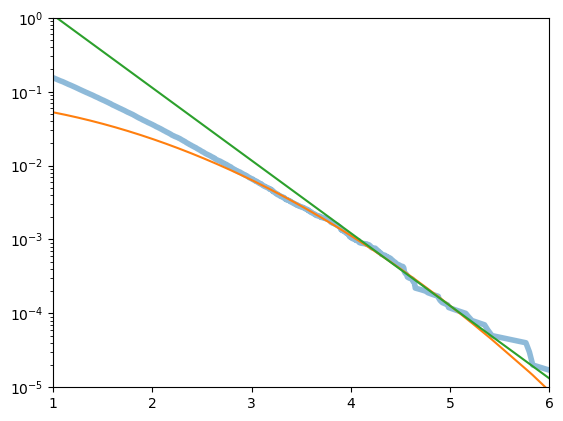

In [50]:
s, c = makecdf(lsnrs - jnp.mean(lsnrs))
pp.semilogy(s, 1 - c, lw=4, alpha=0.5)

mask = (s > 3) & (s < 5)
pp.plot(s, jnp.exp(jnp.polyval(jnp.polyfit(s[mask], jnp.log(1 - c[mask]), 2), s)))

mask = (s > 4) & (s < 5)
pp.plot(s, jnp.exp(jnp.polyval(jnp.polyfit(s[mask], jnp.log(1 - c[mask]), 1), s)))

pp.axis(xmin=1, xmax=6, ymin=1e-5, ymax=1)

In [619]:
jsample, jos = jax.jit(sim.sample), jax.jit(os.os)

In [620]:
key = ds.matrix.jnpkey(42)

oslist = []
for i in tqdm.tqdm(range(1000)):
    key, ys = jsample(key, p0)
    oslist.append(jos({**p0, **{f'{psr.name}_sim_y': y for psr, y in zip(allpsrs, ys)}}))
ssnrs = np.array([o['snr'] for o in oslist])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:00<00:00,  2.08it/s]


In [584]:
%time snrs = os.sample_rhosigma(key, p0, 100).block_until_ready()

CPU times: user 1.85 s, sys: 270 ms, total: 2.12 s
Wall time: 1.12 s


In [585]:
%time snrs = os.sample_rhosigma(key, p0, 1000).block_until_ready()

CPU times: user 4.35 s, sys: 629 ms, total: 4.98 s
Wall time: 1.53 s


In [586]:
%time snrs = os.sample_rhosigma(key, p0, 10000).block_until_ready()

CPU times: user 29.7 s, sys: 3.81 s, total: 33.5 s
Wall time: 5.78 s


In [ ]:
%time snrs2 = os.sample_rhosigma(key, p0, 100000).block_until_ready()

The tail goes from Gaussian to subexponential. The bound is 2 exp(-min(t^2/|Q_F|^2, t/|Q|)).

In [14]:
s, c = makecdf(snrs - jnp.mean(snrs))
pp.semilogy(s, 1 - c, lw=4, alpha=0.5)

mask = (s > 0) & (s < 4)
pp.plot(s[mask], jnp.exp(jnp.polyval(jnp.polyfit(s[mask], jnp.log(1 - c[mask]), 2), s[mask])))

mask = (s > 2) & (s < 4.5)
pp.plot(s[mask], jnp.exp(jnp.polyval(jnp.polyfit(s[mask], jnp.log(1 - c[mask]), 1), s[mask])))

NameError: name 'makecdf' is not defined

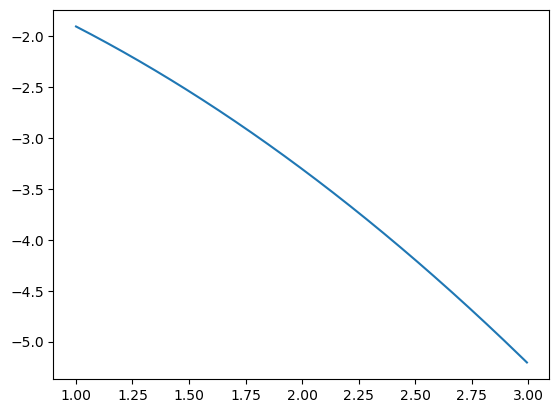

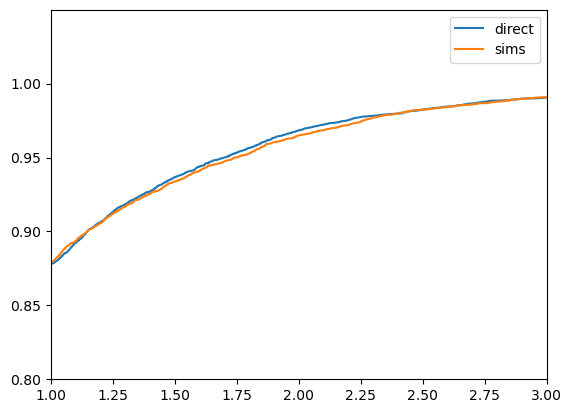

In [595]:
pp.plot(*makecdf(snrs), label='direct')
pp.plot(*makecdf(ssnrs),label='sims')
pp.axis(xmin=1, xmax=3, ymin=0.8); pp.legend()

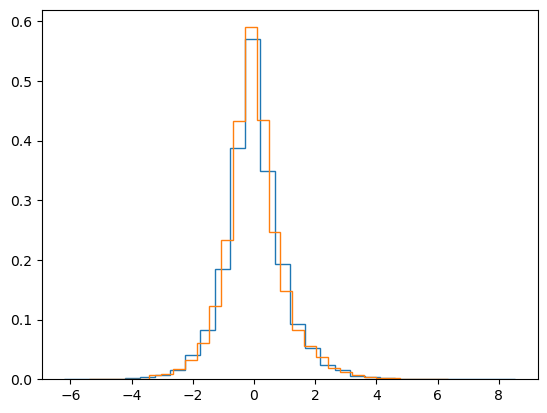

In [588]:
pp.hist(snrs, histtype='step', density=True, bins=30);
pp.hist(ssnrs, histtype='step', density=True, bins=30);

### GX2 distribution

In [260]:
import importlib

importlib.reload(ds.os)
importlib.reload(ds.matrix)
importlib.reload(ds.signals)
importlib.reload(ds.likelihood)
importlib.reload(ds)

<module 'discovery' from '/Users/vallis/Documents/discovery/src/discovery/__init__.py'>

In [122]:
import discovery.ostat as ostat
importlib.reload(ostat)

We will compute the distribution of OS over a set of simulated datasets, and compare with the GP-only GX2 distribution.

In [6]:
Tspan = ds.getspan(allpsrs)

sim = ds.GlobalLikelihood([ds.PulsarLikelihood([ds.makedelay(psr, ds.getresiduals, name='sim'), 
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, variance=1e-12),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in allpsrs])

In [7]:
df = pd.read_feather('../data/NG15yr-m2a-chain.feather')
p0 = df.iloc[df['logp'].argmax()].to_dict()

In [159]:
os = ostat.OS(sim)

Evaluate the OS for the dataset residuals.

In [155]:
os.os({**p0, **{f'{psr.name}_sim_y': psr.residuals for psr in allpsrs}})

{'os': Array(1.13607126e-29, dtype=float64),
 'os_sigma': Array(5.06952954e-30, dtype=float64),
 'snr': Array(2.24097967, dtype=float64),
 'log10_A': -14.186517715454102}

In [168]:
key = ds.matrix.jnpkey(42)

oslist = []
for i in tqdm.tqdm(range(1000)):
    key, ys = sim.sample(key, p0)
    oslist.append(os.os({**p0, **{f'{psr.name}_sim_y': y for psr, y in zip(allpsrs, ys)}}))
snrs = np.array([o['snr'] for o in oslist])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:02<00:00,  1.08s/it]


In [171]:
%%time
xs = np.linspace(-3, 6, 50)
cs = os.gx2cdf(p0, xs, cutoff=1e-6, limit=200, epsabs=1e-6)

CPU times: user 9min 13s, sys: 1min 14s, total: 10min 27s
Wall time: 17min 48s


In [194]:
os.gx2cdf(p0, [1.5], cutoff=1e-6, limit=200, epsabs=1e-6)

array([0.95516926])

In [195]:
os.gx2cdf(p0, [1.5], cutoff=1e-8, limit=200, epsabs=1e-6)

array([0.9551681])

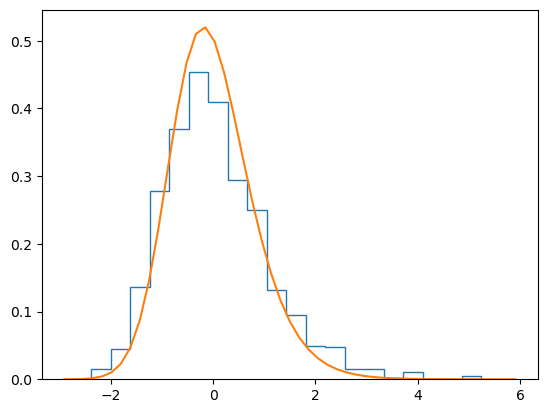

In [175]:
pp.hist(snrs, histtype='step', bins=20, density=True);
pp.plot(0.5*(xs[1:] + xs[:-1]), np.diff(cs) / (xs[1] - xs[0]))

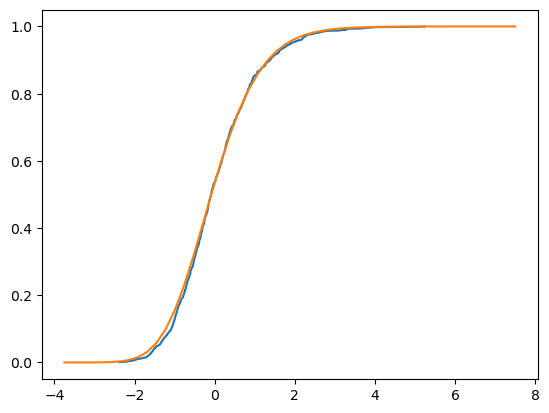

In [205]:
ssnrs = np.sort(snrs)
cdf = np.arange(1, len(ssnrs) + 1) / len(ssnrs)
pp.plot(ssnrs, cdf)

# pp.plot(xs, cs)
pp.plot(1.25 * xs, cs)

In [8]:
Tspan = ds.getspan(allpsrs)

sim2 = ds.GlobalLikelihood([ds.PulsarLikelihood([ds.makedelay(psr, ds.getresiduals, name='sim'), 
                                                 ds.makenoise_measurement(psr, psr.noisedict),
                                                 ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                 ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                   common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                 ]) for psr in allpsrs])

In [223]:
sim2.psls[0].N.N.make_sqrt()({})

Array([1.30327430e-06, 1.06194464e-05, 1.80645535e-06, ...,
       2.20375972e-06, 7.17404447e-07, 1.33880154e-06], dtype=float64)

In [11]:
os2 = ds.OS(sim2)

In [56]:
os2.os({**p0, **{f'{psr.name}_sim_y': psr.residuals for psr in allpsrs}})

{'os': Array(4.28545956e-30, dtype=float64),
 'os_sigma': Array(3.65150911e-30, dtype=float64),
 'snr': Array(1.17361327, dtype=float64),
 'log10_A': -14.186517715454102}

In [62]:
jsim, jos = jax.jit(sim2.sample), jax.jit(os2.os)

In [65]:
key = ds.matrix.jnpkey(42)

oslist2 = []
for i in tqdm.tqdm(range(10000)):
    key, ys = jsim(key, p0)
    oslist2.append(jos({**p0, **{f'{psr.name}_sim_y': y for psr, y in zip(allpsrs, ys)}}))
snrs2 = np.array([o['snr'] for o in oslist2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:12<00:00, 18.09it/s]


In [46]:
%%time
xs2 = np.linspace(-3, 4, 50)
cs2 = os2.gx2cdf(p0, xs2, cutoff=1e-6, limit=200, epsabs=1e-6)

CPU times: user 3min 37s, sys: 22.7 s, total: 3min 59s
Wall time: 30.1 s


Try a direct calculation

In [15]:
%time amat = os2.gx2mat(p0)

CPU times: user 622 ms, sys: 290 ms, total: 912 ms
Wall time: 388 ms


In [50]:
%time
xmat = np.random.randn(10000, amat.shape[0])

CPU times: user 1e+03 ns, sys: 8 μs, total: 9 μs
Wall time: 21.9 μs


In [52]:
%time dsnr = np.sum((xmat @ amat) * xmat, axis=1)

CPU times: user 817 ms, sys: 104 ms, total: 921 ms
Wall time: 88.9 ms


In [59]:
def makecdf(array):
    return np.sort(array), np.arange(1, len(array) + 1) / len(array)

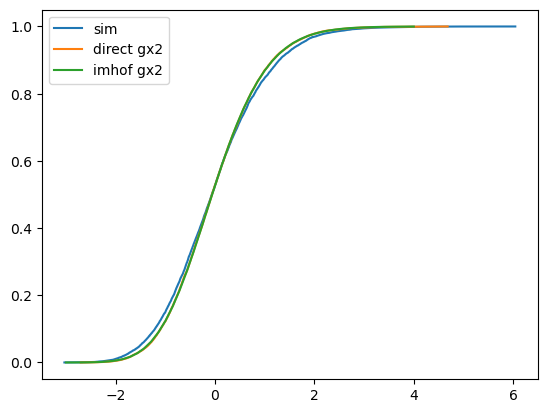

In [67]:
pp.plot(*makecdf(snrs2), label='sim')
pp.plot(*makecdf(dsnr), label='direct gx2')
pp.plot(xs2, cs2, label='imhof gx2')
pp.legend()

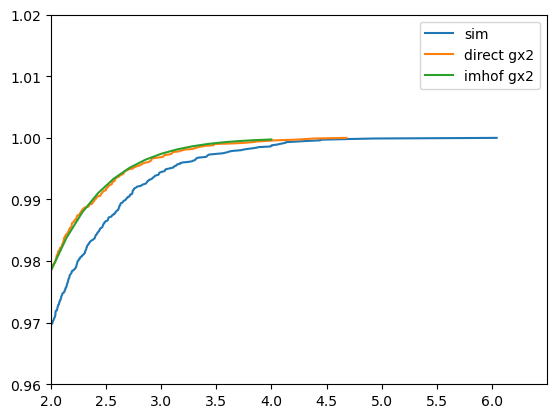

In [80]:
pp.plot(*makecdf(snrs2), label='sim')
pp.plot(*makecdf(dsnr), label='direct gx2')
pp.plot(xs2, cs2, label='imhof gx2')
pp.axis(xmin=2, ymin=0.96, ymax=1.02)
pp.legend()

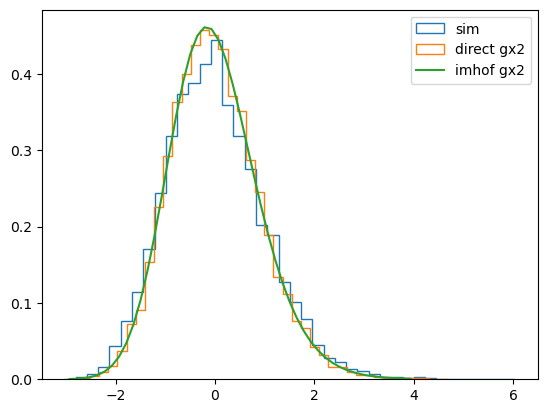

In [75]:
pp.hist(snrs2, histtype='step', bins=40, density=True, label='sim')
pp.hist(dsnr, histtype='step', bins=40, density=True, label='direct gx2')
pp.plot(0.5*(xs2[1:] + xs2[:-1]), np.diff(cs2) / np.diff(xs2)[0], label='imhof gx2')
pp.legend();

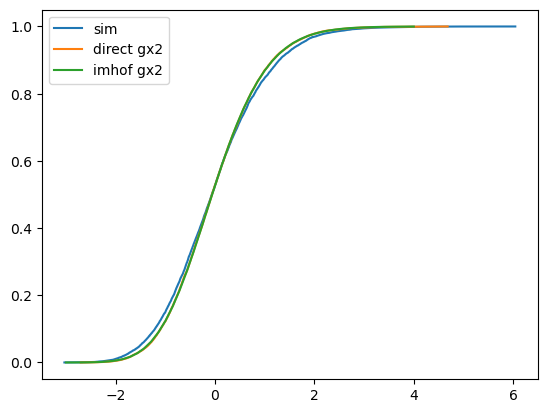

In [107]:
pp.plot(*makecdf(snrs2), label='sim')
pp.plot(*makecdf(dsnr), label='direct gx2')
pp.plot(xs2, cs2, label='imhof gx2')
pp.legend()

In [83]:
def lownoise(noisedict):
    return {par: (val / 10) if 'efac' in par else val - 1 if 'equad' in par else val 
            for par, val in noisedict.items()}

In [87]:
sim2lw = ds.GlobalLikelihood([ds.PulsarLikelihood([ds.makedelay(psr, ds.getresiduals, name='sim'), 
                                                   ds.makenoise_measurement(psr, lownoise(psr.noisedict)),
                                                   ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                   ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                     common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                   ]) for psr in allpsrs])

In [88]:
os2lw = ds.OS(sim2lw)

In [89]:
joslw, jsimlw = jax.jit(os2lw.os), jax.jit(sim2lw.sample)

In [90]:
%time joslw({**p0, **{f'{psr.name}_sim_y': psr.residuals for psr in allpsrs}})

{'log10_A': Array(-14.18651772, dtype=float64, weak_type=True),
 'os': Array(3.4013086e-29, dtype=float64),
 'os_sigma': Array(2.50486393e-30, dtype=float64),
 'snr': Array(13.57881586, dtype=float64)}

In [92]:
%time allys = jsimlw(key, p0)

CPU times: user 1.06 ms, sys: 1.22 ms, total: 2.28 ms
Wall time: 1.26 ms


In [93]:
key = ds.matrix.jnpkey(42)

oslist2lw = []
for i in tqdm.tqdm(range(10000)):
    key, ys = jsimlw(key, p0)
    oslist2lw.append(joslw({**p0, **{f'{psr.name}_sim_y': y for psr, y in zip(allpsrs, ys)}}))
snrs2lw = np.array([o['snr'] for o in oslist2lw])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:09<00:00, 18.19it/s]


In [110]:
%%time
xs2lw = np.linspace(-3, 4, 50)
cs2lw = os2lw.gx2cdf(p0, xs2lw, cutoff=1e-6, limit=200, epsabs=1e-6)

CPU times: user 4min 20s, sys: 25.2 s, total: 4min 45s
Wall time: 33.3 s


In [94]:
%%time
amatlw = os2lw.gx2mat(p0)
xmatlw = np.random.randn(10000, amatlw.shape[0])
dsnrlw = np.sum((xmatlw @ amatlw) * xmatlw, axis=1)

CPU times: user 9.94 s, sys: 635 ms, total: 10.6 s
Wall time: 1.79 s


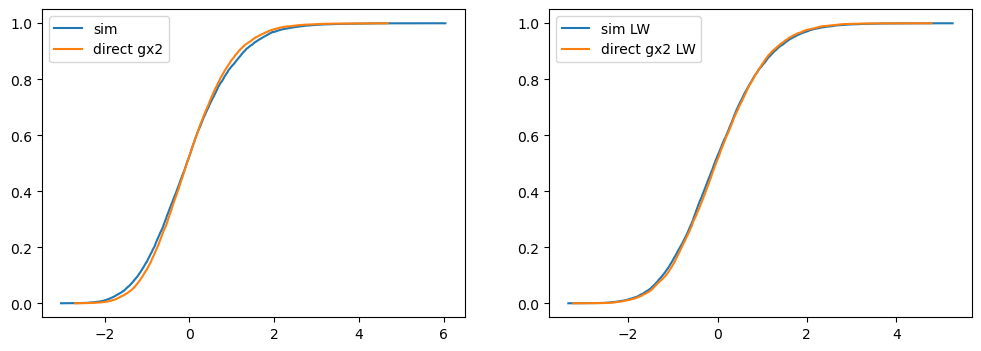

In [111]:
pp.figure(figsize=(12,4))

pp.subplot(1,2,1)
pp.plot(*makecdf(snrs2), label='sim')
pp.plot(*makecdf(dsnr), label='direct gx2')
pp.legend()

pp.subplot(1,2,2)
pp.plot(*makecdf(snrs2lw), label='sim LW')
pp.plot(*makecdf(dsnrlw), label='direct gx2 LW')
pp.legend()

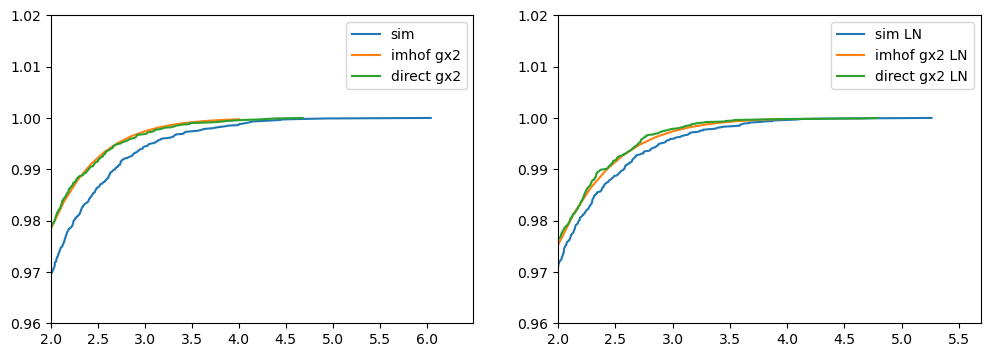

In [112]:
pp.figure(figsize=(12,4))

pp.subplot(1,2,1)
pp.plot(*makecdf(snrs2), label='sim')
pp.plot(xs2, cs2, label='imhof gx2')
pp.plot(*makecdf(dsnr), label='direct gx2')
pp.axis(xmin=2, ymin=0.96, ymax=1.02)
pp.legend()

pp.subplot(1,2,2)
pp.plot(*makecdf(snrs2lw), label='sim LN')
pp.plot(xs2lw, cs2lw, label='imhof gx2 LN')
pp.plot(*makecdf(dsnrlw), label='direct gx2 LN')
pp.axis(xmin=2, ymin=0.96, ymax=1.02)
pp.legend()

In [114]:
def lownoise(noisedict, factor=10):
    return {par: (val / factor) if 'efac' in par else val - np.log10(factor) if 'equad' in par else val 
            for par, val in noisedict.items()}

In [126]:
sim2vlw = ds.GlobalLikelihood([ds.PulsarLikelihood([ds.makedelay(psr, ds.getresiduals, name='sim'), 
                                                    ds.makenoise_measurement(psr, lownoise(psr.noisedict, 100)),
                                                    ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                    ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                      common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                    ]) for psr in allpsrs])

In [127]:
os2vlw = ds.OS(sim2vlw)

In [128]:
josvlw, jsimvlw = jax.jit(os2vlw.os), jax.jit(sim2vlw.sample)

In [129]:
%time josvlw({**p0, **{f'{psr.name}_sim_y': psr.residuals for psr in allpsrs}})

CPU times: user 27.9 s, sys: 1.17 s, total: 29.1 s
Wall time: 29 s


{'log10_A': Array(-14.18651772, dtype=float64, weak_type=True),
 'os': Array(-9.19316003e-28, dtype=float64),
 'os_sigma': Array(2.21382613e-30, dtype=float64),
 'snr': Array(-415.26115837, dtype=float64)}

In [130]:
%time allys = jsimvlw(key, p0)

CPU times: user 10.9 s, sys: 589 ms, total: 11.5 s
Wall time: 11.4 s


In [131]:
key = ds.matrix.jnpkey(42)

oslist2vlw = []
for i in tqdm.tqdm(range(10000)):
    key, ys = jsimvlw(key, p0)
    oslist2vlw.append(josvlw({**p0, **{f'{psr.name}_sim_y': y for psr, y in zip(allpsrs, ys)}}))
snrs2vlw = np.array([o['snr'] for o in oslist2vlw])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:12<00:00, 18.10it/s]


In [133]:
%%time
xs2vlw = np.linspace(-3, 4, 50)
cs2vlw = os2vlw.gx2cdf(p0, xs2vlw, cutoff=1e-6, limit=200, epsabs=1e-6)

CPU times: user 3min 30s, sys: 25.6 s, total: 3min 56s
Wall time: 30.7 s


In [132]:
%%time
amatvlw = os2vlw.gx2mat(p0)
xmatvlw = np.random.randn(10000, amatvlw.shape[0])
dsnrvlw = np.sum((xmatvlw @ amatvlw) * xmatvlw, axis=1)

CPU times: user 8.7 s, sys: 586 ms, total: 9.29 s
Wall time: 1.71 s


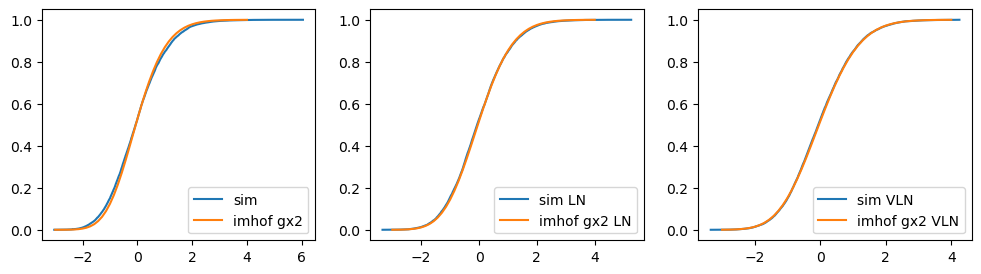

In [142]:
pp.figure(figsize=(12,3))

pp.subplot(1,3,1)
pp.plot(*makecdf(snrs2), label='sim')
pp.plot(xs2, cs2, label='imhof gx2')
pp.legend()

pp.subplot(1,3,2)
pp.plot(*makecdf(snrs2lw), label='sim LN')
pp.plot(xs2lw, cs2lw, label='imhof gx2 LN')
pp.legend()

pp.subplot(1,3,3)
pp.plot(*makecdf(snrs2vlw), label='sim VLN')
pp.plot(xs2vlw, cs2vlw, label='imhof gx2 VLN')
pp.legend()

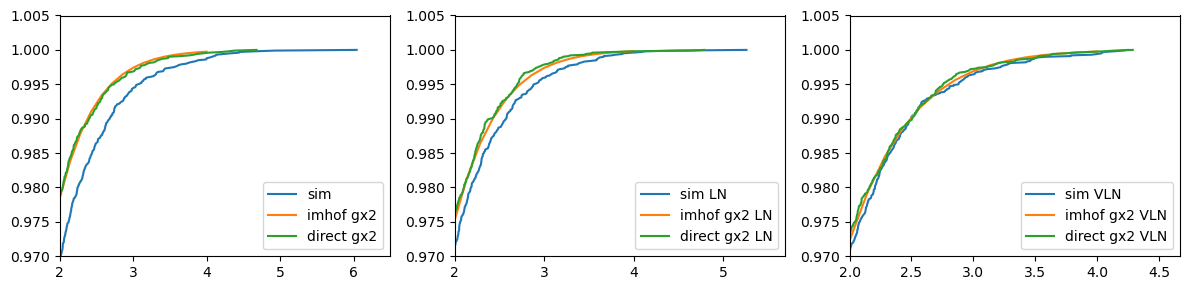

In [139]:
pp.figure(figsize=(12,3))

pp.subplot(1,3,1)
pp.plot(*makecdf(snrs2), label='sim')
pp.plot(xs2, cs2, label='imhof gx2')
pp.plot(*makecdf(dsnr), label='direct gx2')
pp.axis(xmin=2, ymin=0.97, ymax=1.005)
pp.legend()

pp.subplot(1,3,2)
pp.plot(*makecdf(snrs2lw), label='sim LN')
pp.plot(xs2lw, cs2lw, label='imhof gx2 LN')
pp.plot(*makecdf(dsnrlw), label='direct gx2 LN')
pp.axis(xmin=2, ymin=0.97, ymax=1.005)
pp.legend()

pp.subplot(1,3,3)
pp.plot(*makecdf(snrs2vlw), label='sim VLN')
pp.plot(xs2vlw, cs2vlw, label='imhof gx2 VLN')
pp.plot(*makecdf(dsnrvlw), label='direct gx2 VLN')
pp.axis(xmin=2, ymin=0.97, ymax=1.005)
pp.legend()

pp.tight_layout()

In [148]:
def matvec(x):
    return amat @ x

In [168]:
def Lanczos( A, v, m=100 ):
    n = len(v)
    if m>n: m = n;
    # from here https://en.wikipedia.org/wiki/Lanczos_algorithm
    V = np.zeros( (m,n) )
    T = np.zeros( (m,m) )
    vo   = np.zeros(n)
    beta = 0
    for j in range( m-1 ):
        w    = np.dot( A, v )
        alfa = np.dot( w, v )
        w    = w - alfa * v - beta * vo
        beta = np.sqrt( np.dot( w, w ) ) 
        vo   = v
        v    = w / beta 
        T[j,j  ] = alfa 
        T[j,j+1] = beta
        T[j+1,j] = beta
        V[j,:]   = v
    w    = np.dot( A,  v )
    alfa = np.dot( w, v )
    w    = w - alfa * v - beta * vo
    T[m-1,m-1] = np.dot( w, v )
    V[m-1]     = w / np.sqrt( np.dot( w, w ) ) 
    return T, V

In [202]:
def estimate_eigenvalues(A, m=30, num_probes=20, seed=0):
    n = A.shape[0]
    rng = np.random.default_rng(seed)
    all_eigs = []

    for _ in range(num_probes):
        v = rng.normal(size=n)
        v = v / np.linalg.norm(v)
        T, _ = Lanczos(A, v, m)
        eigs = np.linalg.eigvalsh(T)
        all_eigs.append(eigs)

    return np.array(all_eigs)  # shape: (num_probes, m)

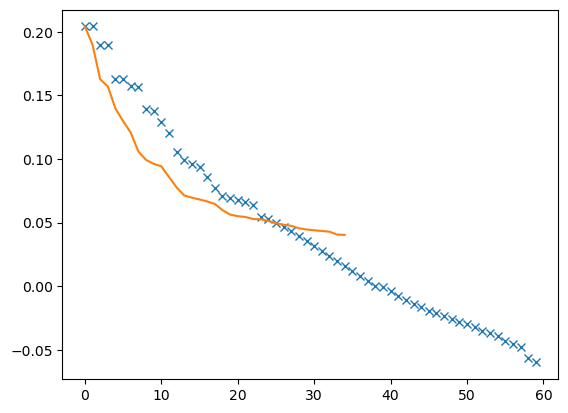

In [217]:
pp.plot(np.sort(np.mean(estimate_eigenvalues(amat, m=60, num_probes=200), axis=0))[::-1], 'x')
pp.plot(np.sort(np.abs(esA))[::-1][:len(esT)])

In [169]:
v0 = np.random.rand(amat.shape[0]); v0 /= np.sqrt(np.dot(v0,v0))

In [200]:
T, V = Lanczos(amat, v0, m=35)
esT, vsT = np.linalg.eig(T)

In [174]:
esA, vsA = np.linalg.eig(amat)

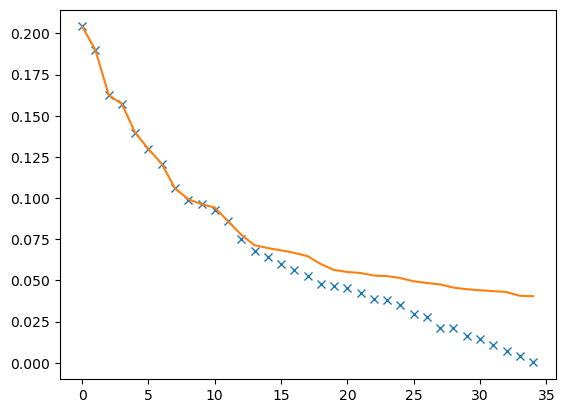

In [201]:
pp.plot(np.sort(np.abs(esT))[::-1], 'x')
pp.plot(np.sort(np.abs(esA))[::-1][:len(esT)])